# NOTEBOOK FOR THE ANALYSIS OF SINGLE-NUCLEI RNA-SEQUENCING DATA FROM MB243

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import bbknn
import scrublet as scr

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [3]:
results_file = '/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/scanpy/MB243-Nuclei_scanpy.h5ad'  # the file that will store the analysis results


## READ IN THE DATA FOR MB243-NUCLEI AND PERFORM DOUBLET REMOVAL WITH SCRUBLET

In [4]:
adata = sc.read_10x_mtx(
    '/icgc/dkfzlsdf/analysis/B260/projects/chromothripsis_medulloblastoma/data/10XRNA5P/MB243/MB243-Nuclei/outs/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()
adata

# make some metadata
adata.obs['sample'] = "MB243"
adata.obs['technology'] = "Nuclei"
adata.obs['patient'] = "MB243"

... reading from cache file cache/icgc-dkfzlsdf-analysis-B260-projects-chromothripsis_medulloblastoma-data-10XRNA5P-MB243-MB243-Nuclei-outs-filtered_feature_bc_matrix-matrix.h5ad


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [5]:
adata.obs

,sample,technology,patient
AAACCTGAGAAACCGC-1,MB243,Nuclei,MB243
AAACCTGAGAACAATC-1,MB243,Nuclei,MB243
AAACCTGAGCACCGTC-1,MB243,Nuclei,MB243
AAACCTGAGCAGCGTA-1,MB243,Nuclei,MB243
AAACCTGAGGAATTAC-1,MB243,Nuclei,MB243
...,...,...,...
TTTGTCATCAATCACG-1,MB243,Nuclei,MB243
TTTGTCATCACCATAG-1,MB243,Nuclei,MB243
TTTGTCATCCCAACGG-1,MB243,Nuclei,MB243
TTTGTCATCGCTTGTC-1,MB243,Nuclei,MB243


In [6]:
scrub = scr.Scrublet(
        counts_matrix=adata.X,
        expected_doublet_rate=0.06,  # Default is 0.1
        random_state=0)

In [7]:
doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.43
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.0%
Elapsed time: 19.8 seconds


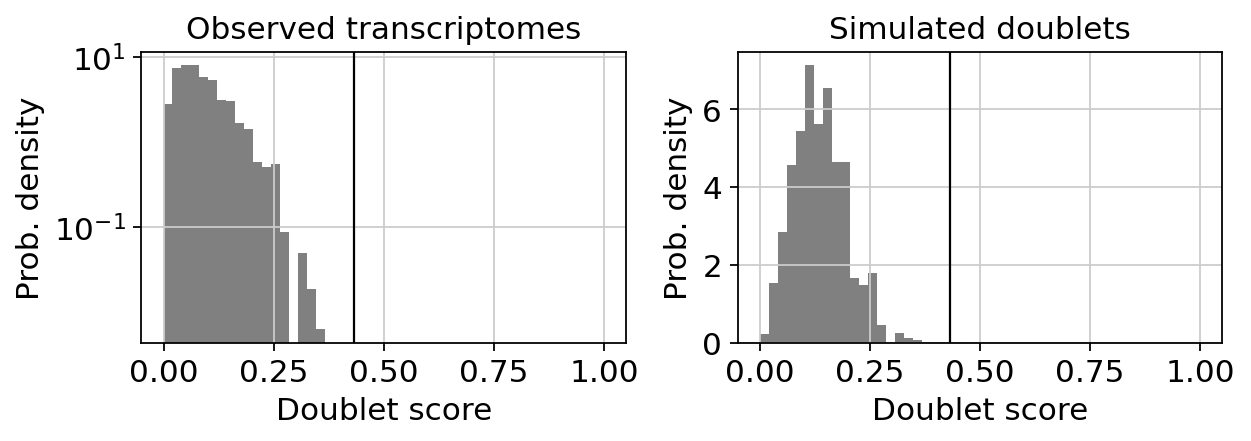

In [8]:
scrub.plot_histogram();

In [9]:
adata.obs['scrublet__predicted_multiplet'] = scrub.predicted_doublets_
adata.obs['scrublet__multiplet_scores'] = scrub.doublet_scores_obs_
adata.obs['scrublet__multiplet_zscores'] = scrub.z_scores_

In [10]:
adata.obs

,sample,technology,patient,scrublet__predicted_multiplet,scrublet__multiplet_scores,scrublet__multiplet_zscores
AAACCTGAGAAACCGC-1,MB243,Nuclei,MB243,False,0.067505,-14.449359
AAACCTGAGAACAATC-1,MB243,Nuclei,MB243,False,0.139767,-5.734176
AAACCTGAGCACCGTC-1,MB243,Nuclei,MB243,False,0.085812,-10.869718
AAACCTGAGCAGCGTA-1,MB243,Nuclei,MB243,False,0.042561,-24.184220
AAACCTGAGGAATTAC-1,MB243,Nuclei,MB243,False,0.202037,-3.188116
...,...,...,...,...,...,...
TTTGTCATCAATCACG-1,MB243,Nuclei,MB243,False,0.054088,-18.586933
TTTGTCATCACCATAG-1,MB243,Nuclei,MB243,False,0.127610,-6.516074
TTTGTCATCCCAACGG-1,MB243,Nuclei,MB243,False,0.139767,-5.734176
TTTGTCATCGCTTGTC-1,MB243,Nuclei,MB243,False,0.107797,-8.163410


In [11]:
# remove predicted doublets
adata = adata[adata.obs['scrublet__predicted_multiplet'] == False]

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


## START PERFORMING THE INITIAL QUALITY CONTROL

/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


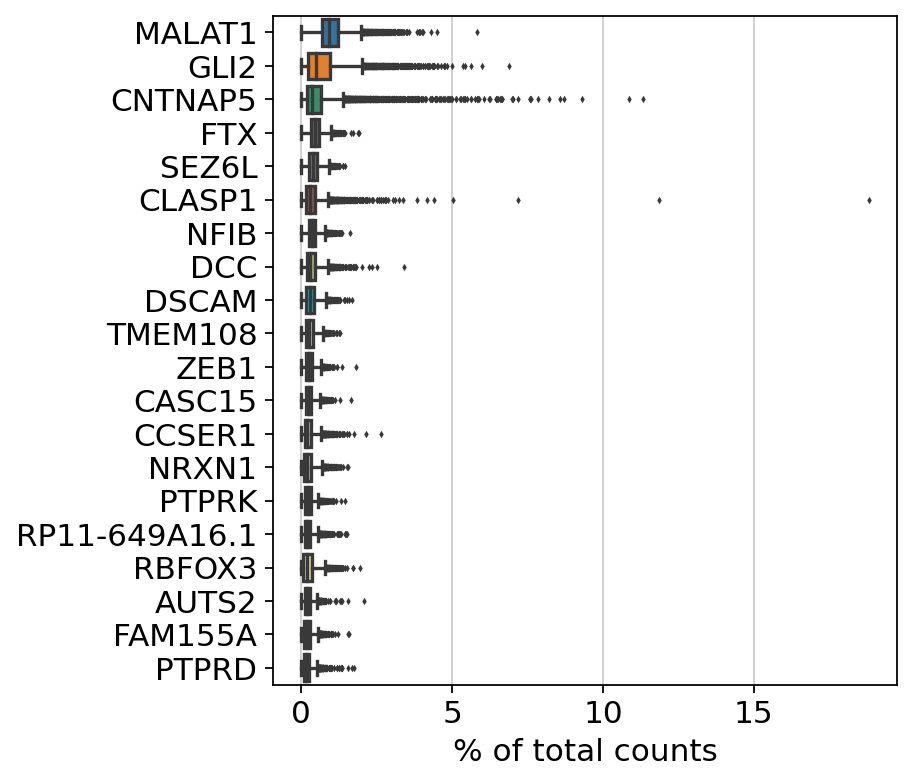

In [12]:
# preprocessing
sc.pl.highest_expr_genes(adata, n_top=20,)

In [13]:
# basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


filtered out 9006 genes that are detected in less than 3 cells


In [14]:
# calculate some quality metrics as for instance mitochondrial percentage
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# and for ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(('RPS','RPL'))  # annotate the group of ribosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata, qc_vars=['ribo'], percent_top=None, log1p=False, inplace=True)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'sample' as categorical
... storing 'technology' as categorical
... storing 'patient' as categorical
... storing 'feature_types' as categorical


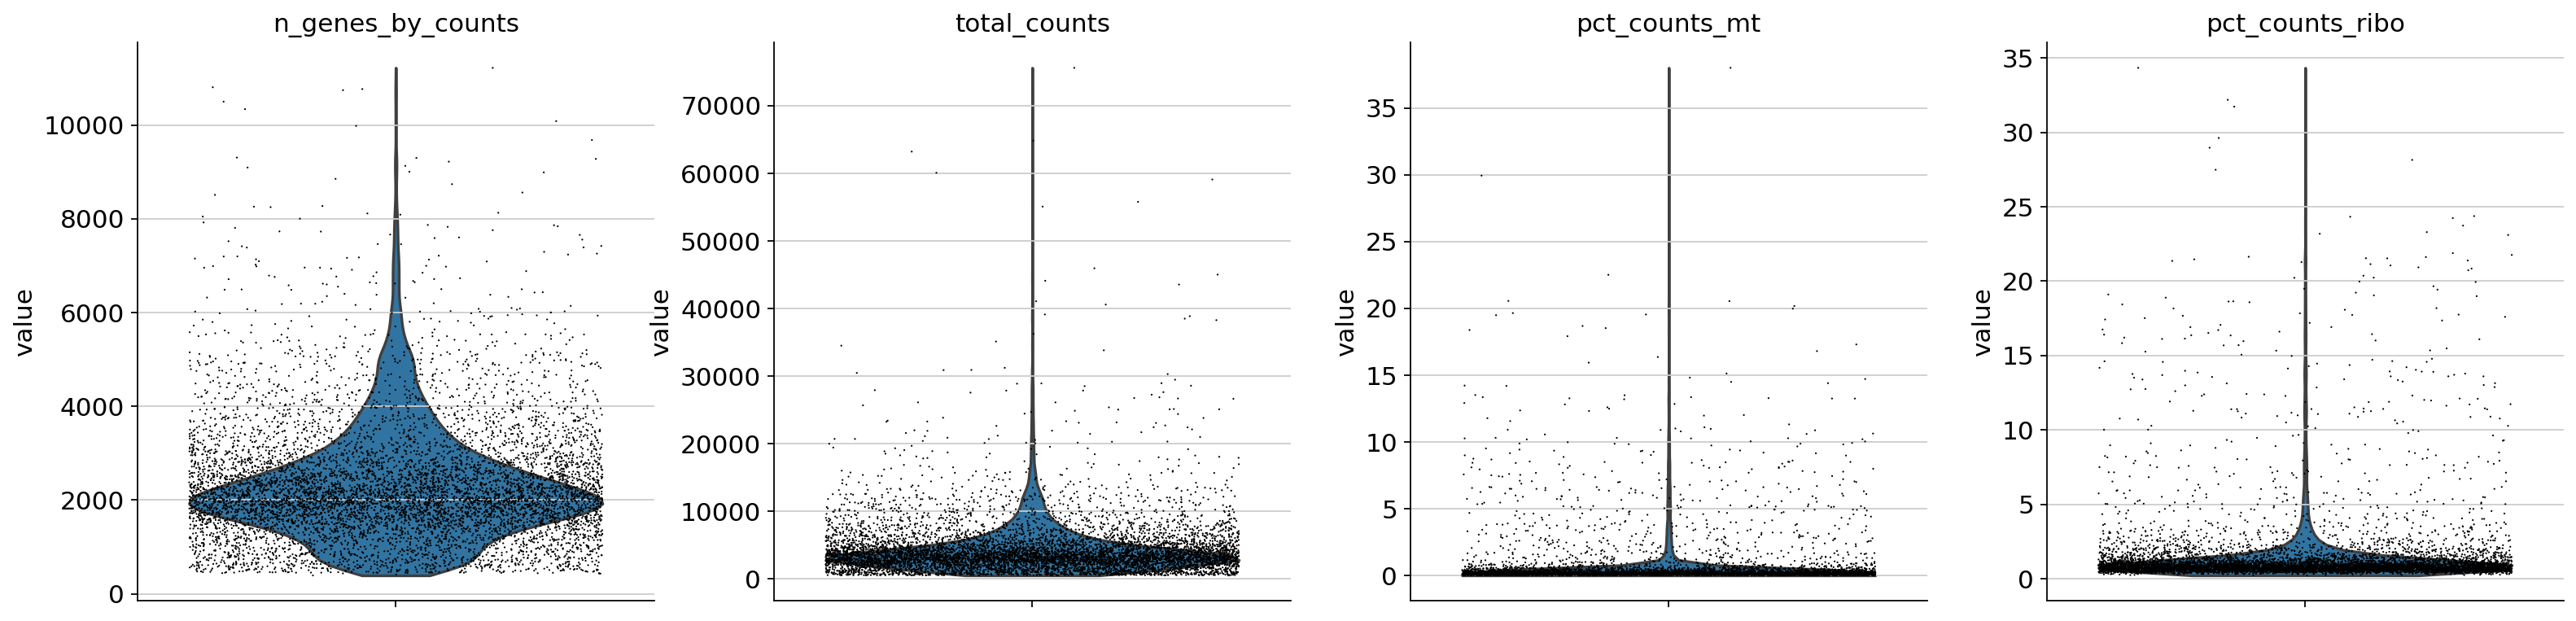

In [15]:
# visualize some QC metrics
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'],
             jitter=0.4, multi_panel=True)

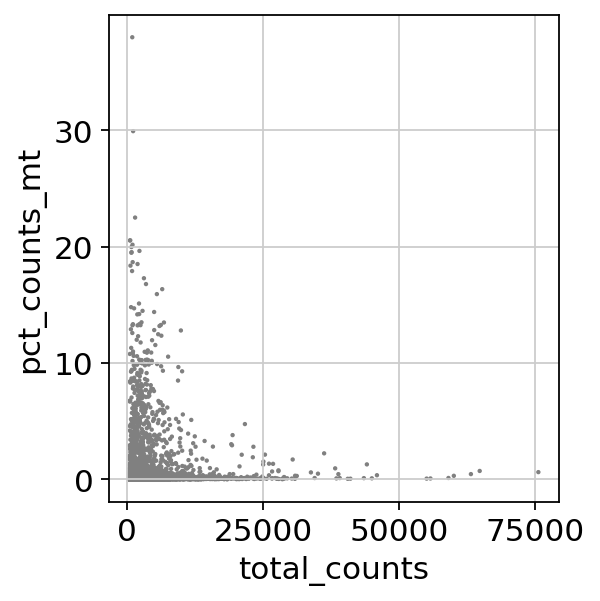

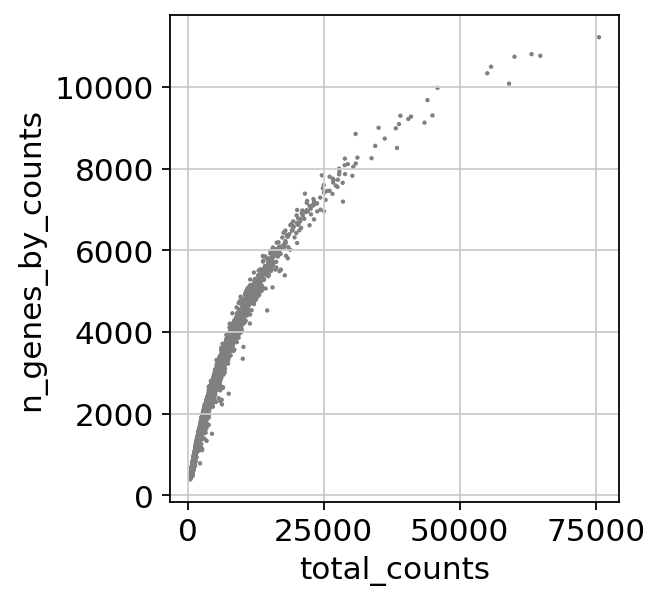

In [16]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [17]:
# do the actual filtering by slicing the object
adata = adata[300 < adata.obs.n_genes_by_counts, :]
adata = adata[adata.obs.n_genes_by_counts < 6000, :]
adata = adata[500 < adata.obs.total_counts, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata = adata[adata.obs.pct_counts_ribo < 10, :]

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [18]:
adata

View of AnnData object with n_obs × n_vars = 7302 × 23732
    obs: 'sample', 'technology', 'patient', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo'

In [19]:
# calculate mean number of genes detected
mean_genes = adata.obs['n_genes'].mean()
print(mean_genes)

# calculate mean number of transcripts detected
mean_counts = adata.obs['total_counts'].mean()
print(mean_counts)

2256.308545603944
4037.484619140625


## PERFORM NORMALIZATION, PCA AND CLUSTERING

In [20]:
sc.pp.normalize_total(adata, target_sum=1e4)

/home/przybilm/.local/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [21]:
sc.pp.log1p(adata)

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


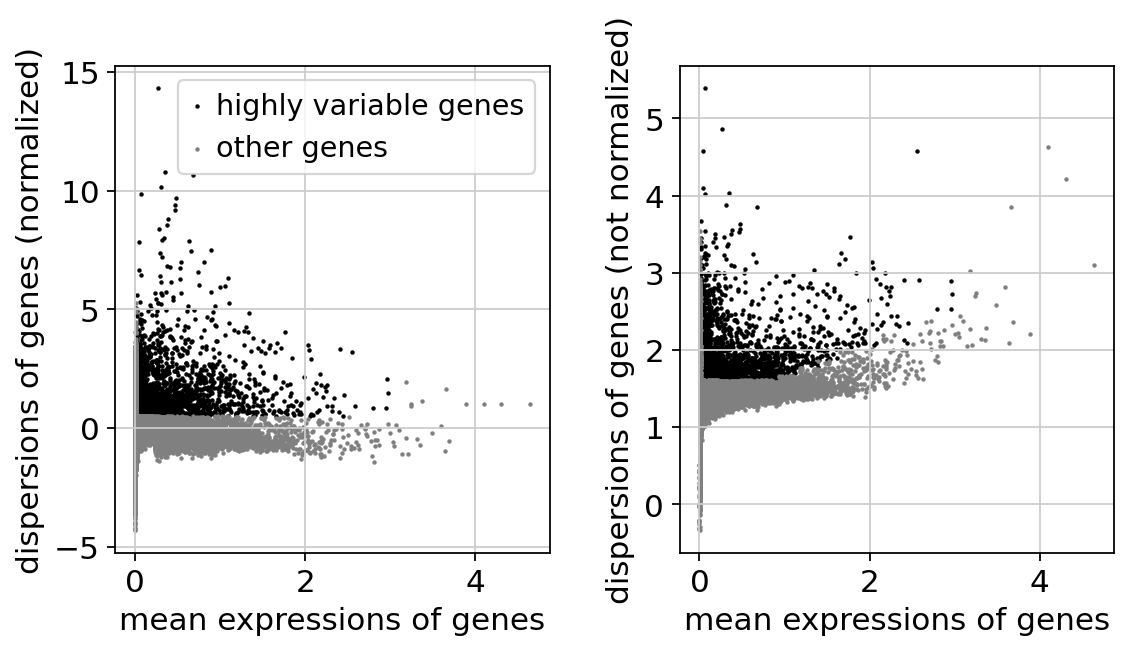

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
# set the raw attribute of anndata
adata.raw = adata

In [25]:
adata = adata[:, adata.var.highly_variable]

In [26]:
# regress out effects of total counts per cell and the percentage of mitochondrial genes
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

regressing out ['total_counts', 'pct_counts_mt', 'pct_counts_ribo']
    sparse input is densified and may lead to high memory use
    finished (0:00:31)


In [27]:
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


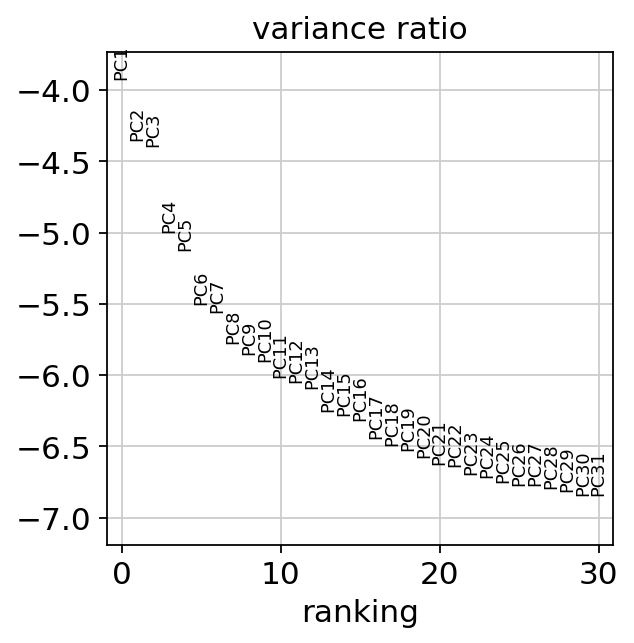

In [28]:
sc.pl.pca_variance_ratio(adata, log=True)

In [29]:
adata.write(results_file)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


In [30]:
adata

AnnData object with n_obs × n_vars = 7302 × 3339
    obs: 'sample', 'technology', 'patient', 'scrublet__predicted_multiplet', 'scrublet__multiplet_scores', 'scrublet__multiplet_zscores', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'ribo', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [31]:
# compute nearest neighbors, UMAP and clustering
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=8)
sc.tl.umap(adata, n_components=2, min_dist=0.1,  # Scanpy default = 0.05
           spread=1.0, copy=False, random_state=0)
sc.tl.louvain(adata, resolution= 0.4)
sc.tl.leiden(adata, resolution= 0.2)

computing neighbors
    using 'X_pca' with n_pcs = 8
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


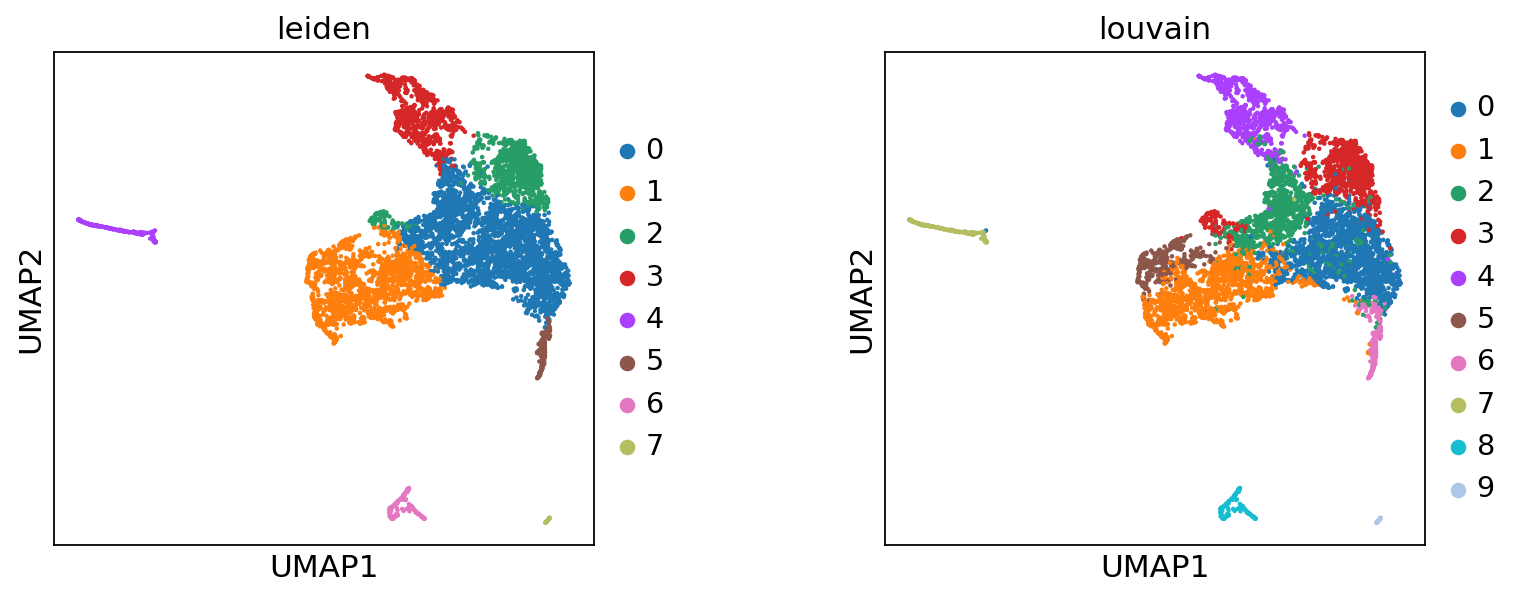

In [32]:
sc.pl.umap(adata, color=['leiden', 'louvain'], save = '_MB243-Nuclei.pdf', wspace = 0.4)

In [33]:
adata.write(results_file)

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:19)


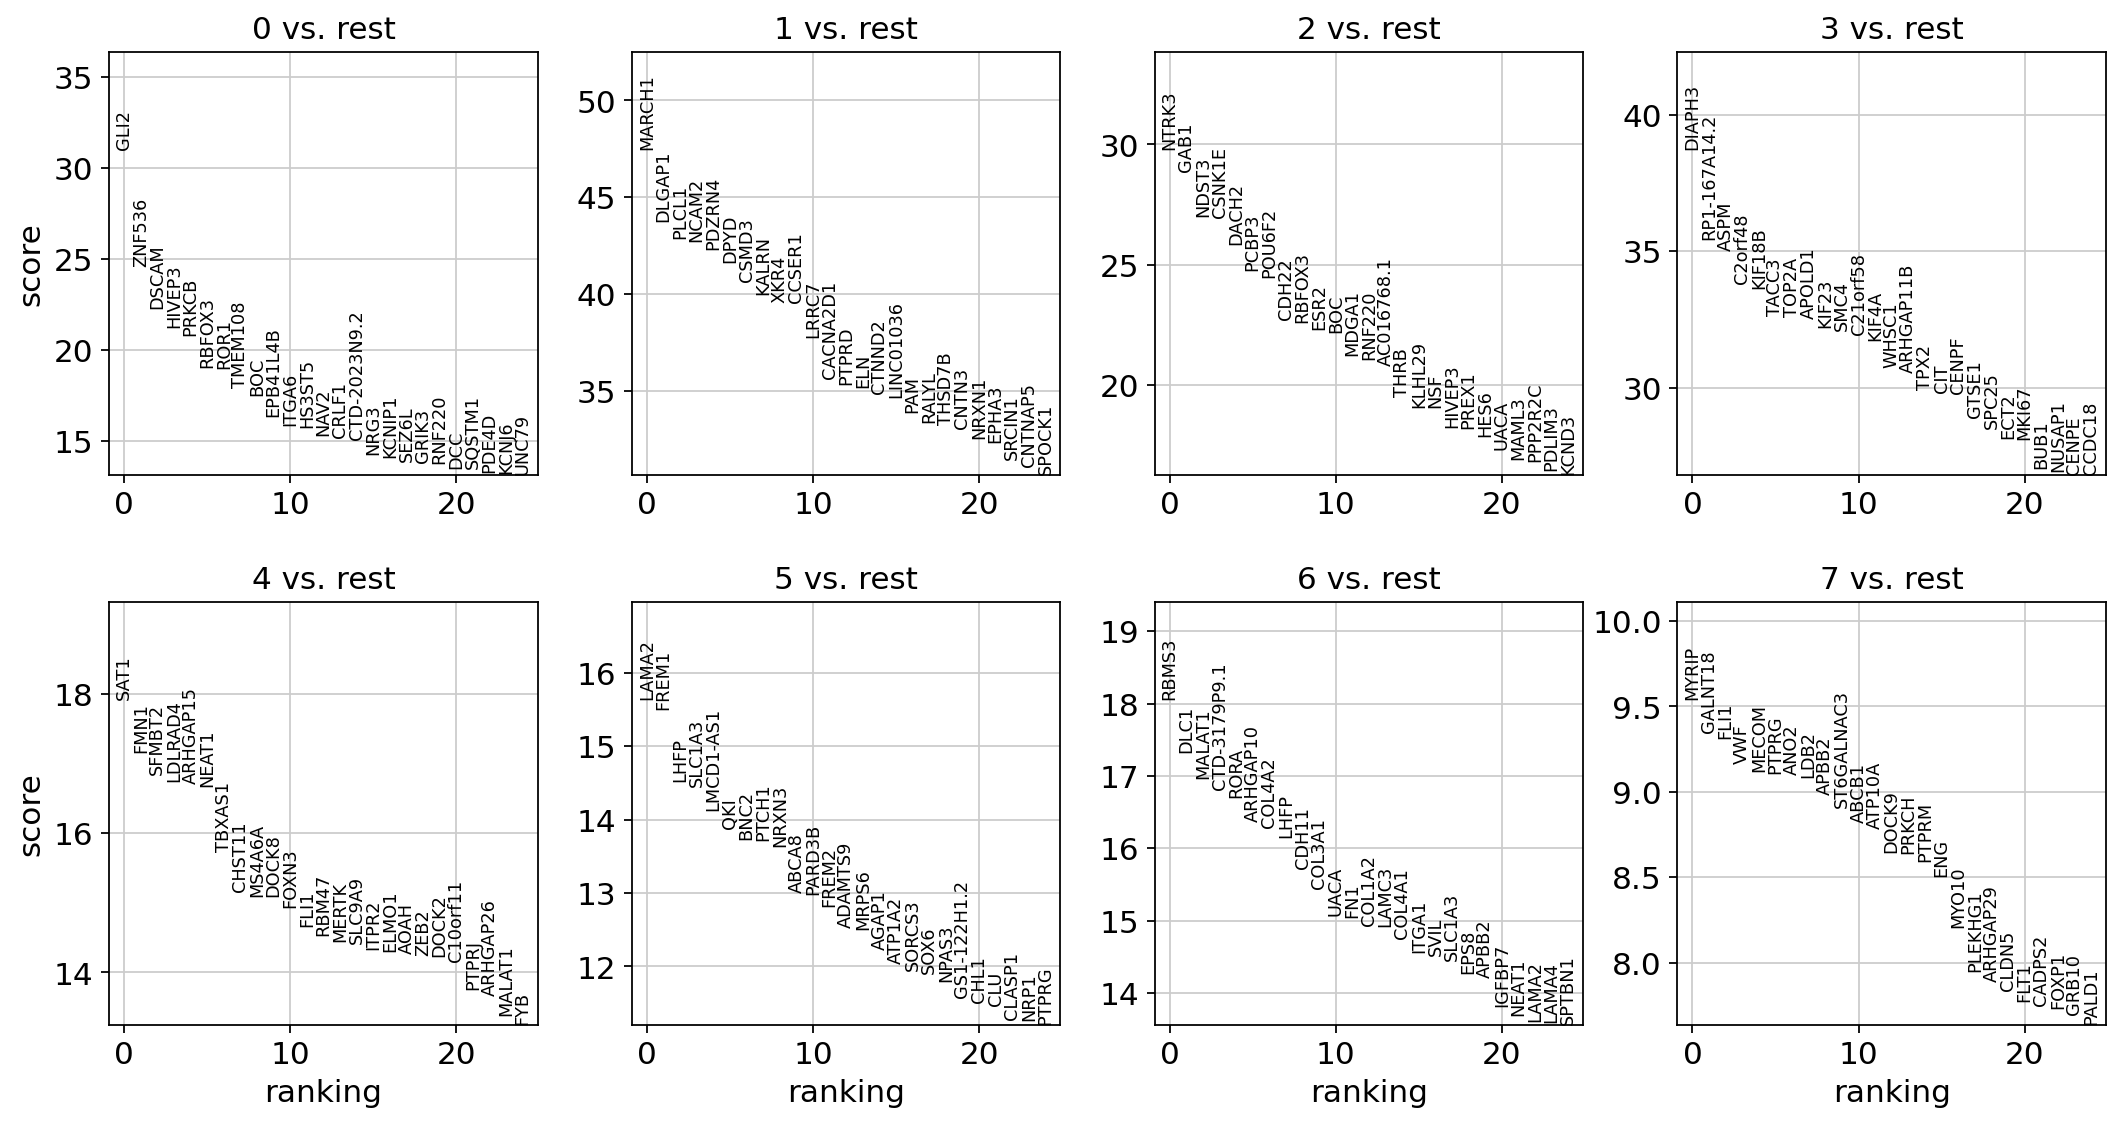

In [34]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, save = "_MB243-Nuclei_leiden.pdf")

In [35]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', "scores", 'logfoldchanges', "pvals", 'pvals_adj']})

In [36]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/MB243_DEG_wilcoxon.csv")

In [37]:
wilcoxon_df

,0_n,0_s,0_l,0_p,1_n,1_s,1_l,1_p,2_n,2_s,...,5_l,5_p,6_n,6_s,6_l,6_p,7_n,7_s,7_l,7_p
0,GLI2,31.037891,1.057537,3.944455e-207,MARCH1,47.476772,2.635506,0.000000e+00,NTRK3,29.796991,...,1.812973,9.116808e-51,RBMS3,18.061289,5.171237,1.526031e-68,MYRIP,9.542668,5.563497,3.303568e-17
1,ZNF536,24.568985,0.672876,2.144715e-129,DLGAP1,43.769634,2.521353,0.000000e+00,GAB1,28.869959,...,2.696561,4.424627e-50,DLC1,17.328661,8.388729,3.392612e-63,GALNT18,9.347411,7.051294,9.793082e-17
2,DSCAM,22.298138,0.527286,1.828329e-106,PLCL1,42.902317,2.882963,0.000000e+00,NDST3,27.013849,...,4.685343,7.230112e-44,MALAT1,16.972395,1.057525,1.039946e-60,FLI1,9.313407,7.452648,9.793082e-17
3,HIVEP3,21.214748,0.724664,2.760818e-96,NCAM2,42.709518,2.873315,0.000000e+00,CSNK1E,26.954912,...,3.405818,1.432216e-43,CTD-3179P9.1,16.809828,8.720617,1.226759e-59,VWF,9.163856,9.810876,2.970988e-16
4,PRKCB,20.766165,1.341364,2.969174e-92,PDZRN4,42.327454,3.850083,0.000000e+00,DACH2,25.867548,...,3.488355,1.040808e-41,RORA,16.704172,3.051138,5.800707e-59,MECOM,9.120922,5.489264,3.016690e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23727,DOCK4,-18.283674,-0.979987,2.208000e-71,CDK6,-27.964590,-1.044497,2.810587e-169,PLXDC2,-16.816824,...,-1.077411,8.239095e-30,GLI2,-13.123561,-2.056474,1.847457e-36,FTX,-5.927285,-0.769515,8.305798e-07
23728,CCSER1,-19.586481,-0.573490,5.317339e-82,PTCH1,-28.191572,-1.865971,4.890366e-172,CLASP1,-17.480717,...,-1.289445,1.110141e-30,NFIB,-13.210465,-1.071155,6.039878e-37,CTNNA2,-5.990930,-1.785241,5.894711e-07
23729,NCAM2,-19.808687,-1.291638,7.432150e-84,POU6F2,-28.524588,-1.204661,3.936862e-176,LINC00478,-18.511482,...,-1.486778,3.888934e-32,TMEM108,-13.558252,-1.662573,6.001079e-39,CASC15,-6.367419,-1.593889,6.709006e-08
23730,PLCL1,-23.290657,-1.511638,3.271048e-116,LAMA2,-28.579350,-1.159864,8.469744e-177,CNTN3,-18.767065,...,-1.249908,3.704640e-35,GPM6A,-14.040103,-1.941179,9.555723e-42,TMEM108,-6.420586,-1.676425,4.808409e-08


In [38]:
new_cluster_names = ['cluster0', 'cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5', 'cluster6', 'cluster7']
adata.rename_categories('leiden', new_cluster_names)

old_to_new = dict(
    cluster0='malignant basal state',
    cluster1='malignant neuronal development',
    cluster2='malignant SHH',
    cluster3='malignant cycling',
    cluster4='macrophages',
    cluster5='astrocytes',
    cluster6='meninge cells',
    cluster7='endothelial cells',
)

adata.obs['new_clusters'] = (
    adata.obs['leiden']
    .map(old_to_new)
    .astype('category')
)

/home/przybilm/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


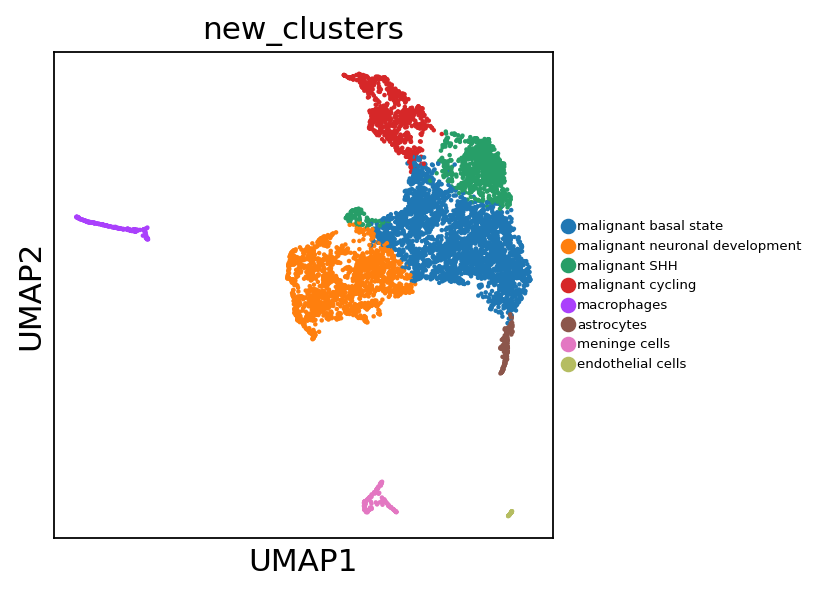

In [42]:
sc.pl.umap(adata, color=['new_clusters'], save = '_MB243-Nuclei_CellType.pdf', wspace = 0.6, legend_fontsize = 6)

In [40]:
adata.write("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/MB243-Nuclei_Aurelie_Celltype_scanpy.h5ad")

In [41]:
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/MB243-Nuclei_metadata.csv')

## PROJECT THE ALIGNED SCDNA-CLONES ON THE EMBEDDING

In [ ]:
adata = sc.read("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/MB243-Nuclei_Aurelie_Celltype_scanpy.h5ad")

In [43]:
scDNA_clones = pd.read_csv("/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/MB243-Nuclei/MB243-Nuclei_scDNA_clones_filtered_cells.txt", sep = '\t', index_col=0)
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone3,Clone4,Clone5,Clone1_pval,Clone2_pval,Clone3_pval,Clone4_pval,Clone5_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,,,,,,,
AGGTCATTCAAGCCTA-1,Clone2,0.538949,0.000684,0.538949,0.501844,0.508322,0.518952,1.001,0.001,0.001,0.001,0.001,4,0.001,0.005
CTCGAAATCAAGGTAA-1,Clone3,0.530517,-0.003507,0.455145,0.530517,0.436133,0.420044,1.001,0.001,0.001,0.001,0.085,3,0.001,0.005
CACACAATCTGTCTCG-1,Clone3,0.578142,-0.006266,0.519190,0.578142,0.531083,0.514258,1.001,0.001,0.001,0.001,0.001,4,0.001,0.005
GGACATTTCCGTACAA-1,Clone3,0.531867,0.001968,0.484609,0.531867,0.463018,0.444966,1.001,0.001,0.001,0.001,0.009,3,0.001,0.005
ACAGCTAGTCTAAAGA-1,Clone2,0.515616,0.002570,0.515616,0.497955,0.504684,0.509022,1.001,0.001,0.001,0.001,0.001,4,0.001,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACGGATTCTATCCTA-1,Clone4,0.432330,-0.007630,0.428019,0.399951,0.432330,0.408143,1.001,0.001,0.001,0.001,0.001,4,0.001,0.005
AGGTCCGAGACTAGAT-1,Clone5,0.517202,0.005306,0.501647,0.451137,0.514248,0.517202,1.001,0.001,0.073,0.001,0.001,3,0.001,0.005
CGGAGTCTCCACGACG-1,Clone4,0.520406,-0.003760,0.514103,0.430806,0.520406,0.517717,1.001,0.001,0.864,0.001,0.001,3,0.001,0.005


In [44]:
scDNA_clones = scDNA_clones.loc[scDNA_clones['padj'] <= 0.05, :]
scDNA_clones

,clone_id,pearson.correlation,Clone1,Clone2,Clone3,Clone4,Clone5,Clone1_pval,Clone2_pval,Clone3_pval,Clone4_pval,Clone5_pval,num_pval_clones,min_pval,padj
Cell_barcode,,,,,,,,,,,,,,,
AGGTCATTCAAGCCTA-1,Clone2,0.538949,0.000684,0.538949,0.501844,0.508322,0.518952,1.001,0.001,0.001,0.001,0.001,4,0.001,0.005
CTCGAAATCAAGGTAA-1,Clone3,0.530517,-0.003507,0.455145,0.530517,0.436133,0.420044,1.001,0.001,0.001,0.001,0.085,3,0.001,0.005
CACACAATCTGTCTCG-1,Clone3,0.578142,-0.006266,0.519190,0.578142,0.531083,0.514258,1.001,0.001,0.001,0.001,0.001,4,0.001,0.005
GGACATTTCCGTACAA-1,Clone3,0.531867,0.001968,0.484609,0.531867,0.463018,0.444966,1.001,0.001,0.001,0.001,0.009,3,0.001,0.005
ACAGCTAGTCTAAAGA-1,Clone2,0.515616,0.002570,0.515616,0.497955,0.504684,0.509022,1.001,0.001,0.001,0.001,0.001,4,0.001,0.005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TACGGATTCTATCCTA-1,Clone4,0.432330,-0.007630,0.428019,0.399951,0.432330,0.408143,1.001,0.001,0.001,0.001,0.001,4,0.001,0.005
AGGTCCGAGACTAGAT-1,Clone5,0.517202,0.005306,0.501647,0.451137,0.514248,0.517202,1.001,0.001,0.073,0.001,0.001,3,0.001,0.005
CGGAGTCTCCACGACG-1,Clone4,0.520406,-0.003760,0.514103,0.430806,0.520406,0.517717,1.001,0.001,0.864,0.001,0.001,3,0.001,0.005


In [45]:
adata.obs['clone_id'] = scDNA_clones['clone_id']
adata.obs['padj'] = scDNA_clones['padj']

In [46]:
adata.uns['clone_id_colors'] = np.array(["#E41A1C", "#377EB8", "#4DAF4A", "#984EA3", "#FF7F00", "#808080"])

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'clone_id' as categorical


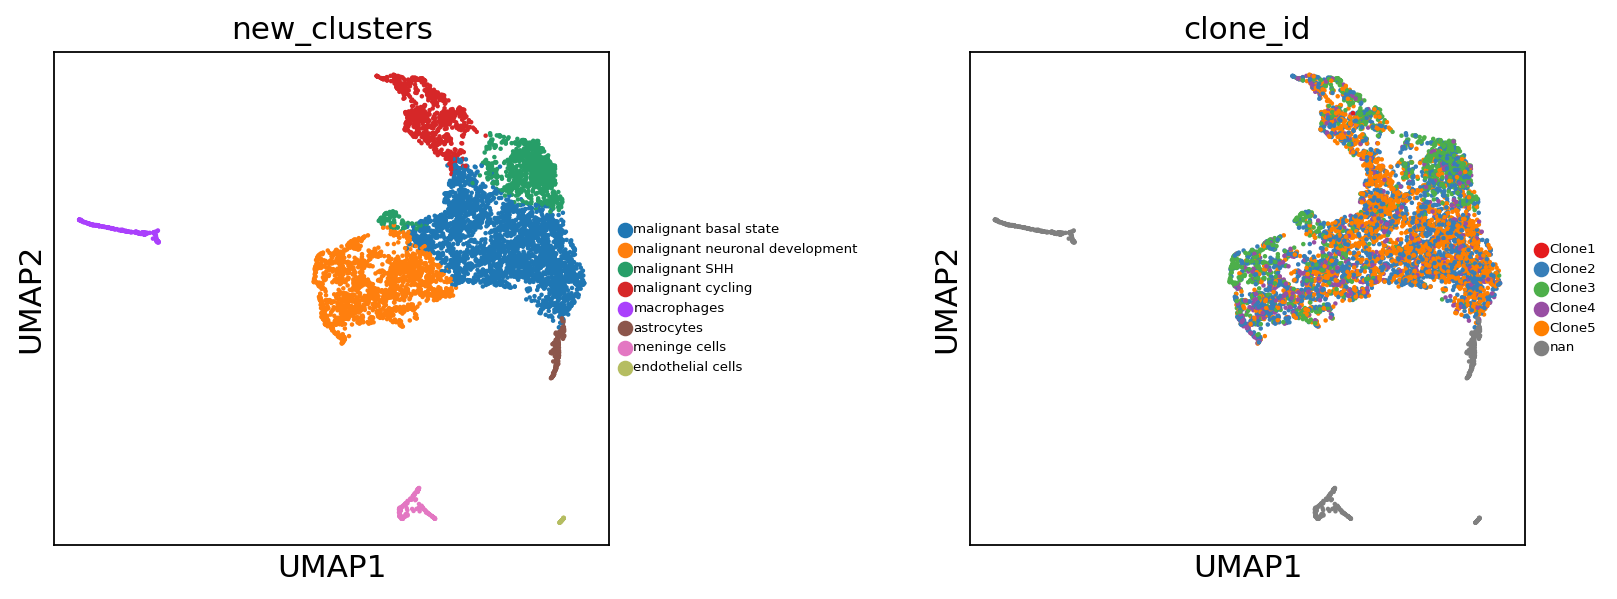

In [47]:
sc.pl.umap(adata, color=['new_clusters', 'clone_id'], save = '_MB243-Nuclei_scDNA_clones_integrated.pdf', wspace = 0.5, legend_fontsize = 6)

In [48]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/infercnv_MB/MB243-Nuclei_metadata.csv')

ranking genes


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:17)


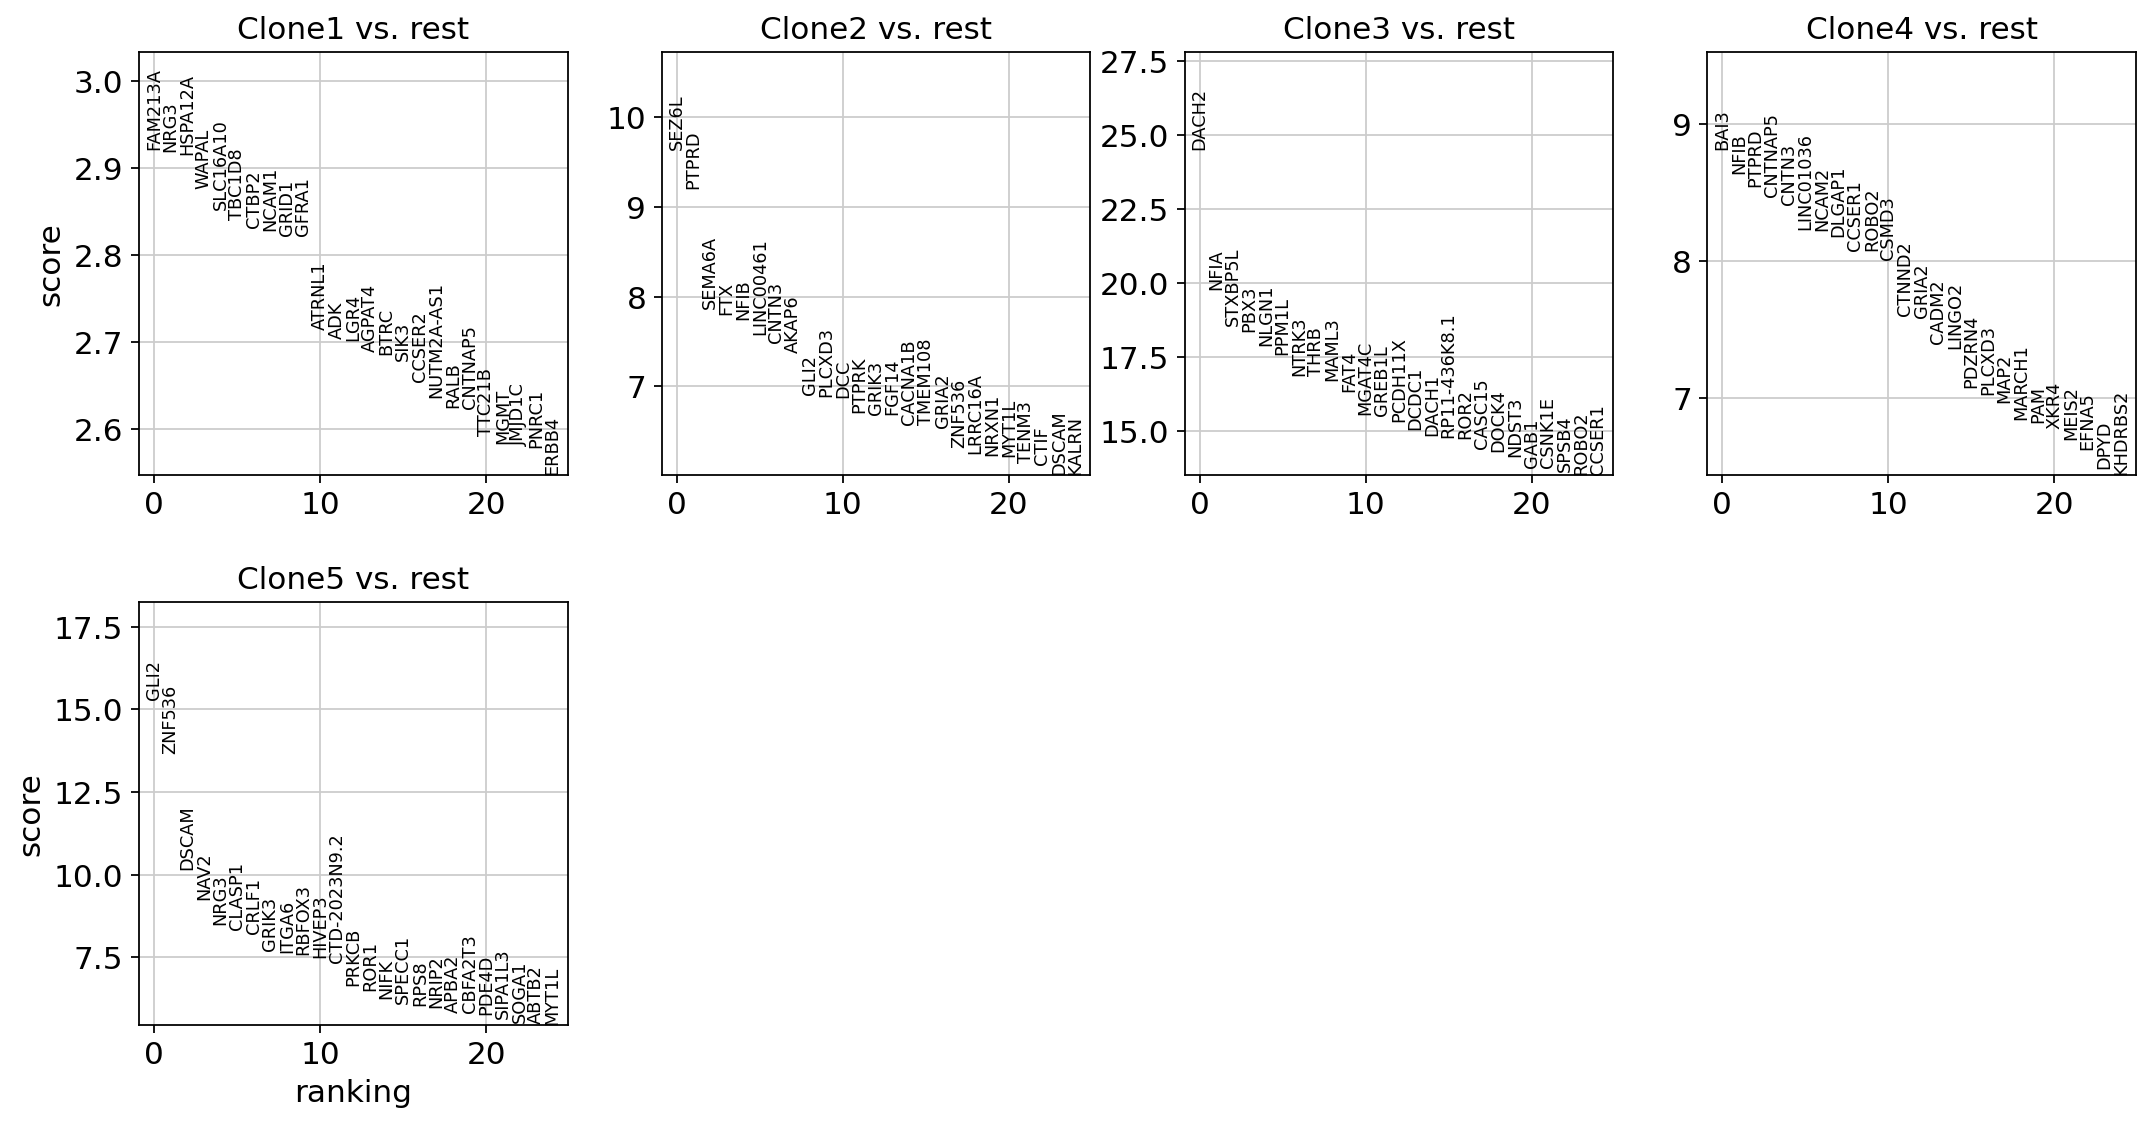

In [49]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(
            adata,
            groupby='clone_id',
            groups=["Clone1", 'Clone2', 'Clone3', 'Clone4', 'Clone5'],
            reference='rest',
            use_raw=True,
            method='wilcoxon',
            n_genes=2000,
            corr_method='benjamini-hochberg'
        )
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [50]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'scores',  "pvals", 'pvals_adj']})

In [51]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/MB243-Nuclei_DEG_wilcoxon_integrated_scDNA_clones_only.csv")

In [52]:
wilcoxon_df

,Clone1_n,Clone1_l,Clone1_s,Clone1_p,Clone2_n,Clone2_l,Clone2_s,Clone2_p,Clone3_n,Clone3_l,Clone3_s,Clone3_p,Clone4_n,Clone4_l,Clone4_s,Clone4_p,Clone5_n,Clone5_l,Clone5_s,Clone5_p
0,FAM213A,4.946233,2.921107,1.0,SEZ6L,0.300807,9.638474,1.305247e-17,DACH2,1.821609,24.505533,3.060377e-128,BAI3,0.483524,8.816642,2.799053e-14,GLI2,0.592188,15.306602,1.639381e-48
1,NRG3,3.257853,2.918367,1.0,PTPRD,0.330452,9.203150,4.124732e-16,NFIA,0.839449,19.790659,4.251875e-83,NFIB,0.266271,8.644646,6.404377e-14,ZNF536,0.373564,13.666577,1.907823e-38
2,HSPA12A,5.076315,2.914806,1.0,SEMA6A,0.299386,7.864140,2.939931e-11,STXBP5L,1.024662,18.582550,3.519131e-73,PTPRD,0.460105,8.548965,9.824831e-14,DSCAM,0.296645,10.147288,5.390292e-21
3,WAPAL,4.411586,2.876592,1.0,FTX,0.168874,7.804606,3.541272e-11,PBX3,1.001350,18.379211,1.143599e-71,CNTNAP5,0.536166,8.469570,1.461296e-13,NAV2,0.361984,9.237535,2.137929e-17
4,SLC16A10,4.390232,2.852212,1.0,NFIB,0.178130,7.741006,4.681526e-11,NLGN1,0.689627,17.887878,6.957407e-68,CNTN3,0.772441,8.417063,1.832312e-13,NRG3,0.391876,8.496344,1.132515e-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,PRKAA1,1.182173,0.501301,1.0,ZC2HC1A,0.060562,0.872322,1.000000e+00,LMO4,0.152760,2.234891,2.721577e-01,EEF1D,0.104913,1.018468,1.000000e+00,TSKU,0.167706,0.250514,1.000000e+00
1996,C12orf4,1.505766,0.500890,1.0,CEP68,0.083877,0.871920,1.000000e+00,KDM6A,0.162992,2.234560,2.722681e-01,KIAA1549,0.122974,1.018121,1.000000e+00,SYNE4,0.402206,0.250514,1.000000e+00
1997,KSR2,1.176059,0.500753,1.0,MSL1,0.083153,0.871778,1.000000e+00,NPS,0.995614,2.234221,2.723837e-01,ATP6AP1L,0.215522,1.017956,1.000000e+00,SYT8,0.202232,0.250212,1.000000e+00
1998,SLC25A53,1.159244,0.500616,1.0,DHPS,0.096123,0.871731,1.000000e+00,RP11-393I2.4,1.240084,2.232334,2.733455e-01,BNIP3L,0.129233,1.017802,1.000000e+00,RBM4B,0.121141,0.250188,1.000000e+00


In [ ]:
# find marker genes for each cluster using the Wilcoxon rank sum test
sc.tl.rank_genes_groups(
            adata,
            groupby='clone_id',
            groups=["Clone1", 'Clone2', 'Clone3', 'Clone4', 'Clone5', 'nan'],
            reference="nan",
            use_raw=True,
            method='wilcoxon',
            n_genes=5000,
            corr_method='benjamini-hochberg'
        )
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
wilcoxon_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'scores',  "pvals", 'pvals_adj']})

In [ ]:
wilcoxon_df.to_csv("/omics/groups/OE0540/internal/projects/przybilm/medulloblastoma/revision/scrna_analysis/scanpy/MB243-Nuclei_DEG_wilcoxon_integrated_scDNA_clones_vs_normal_cells.csv")

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


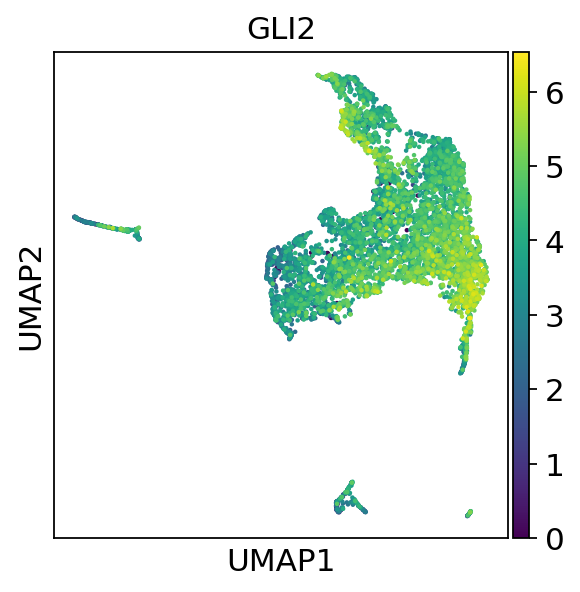

In [53]:
sc.pl.umap(adata, color=['GLI2'], wspace = 0.5, save = '_MB243-Nuclei_GLI2_marker_visualization.pdf')

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


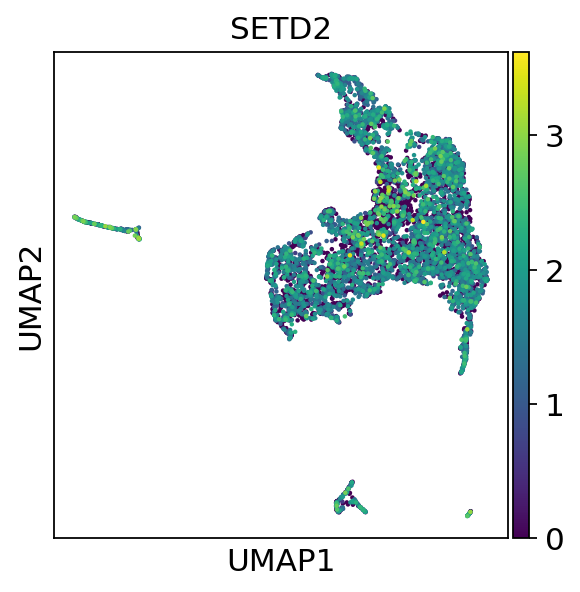

In [54]:
sc.pl.umap(adata, color=['SETD2'], wspace = 0.5, save = '_MB243-Nuclei_SETD2_marker_visualization.pdf')

/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


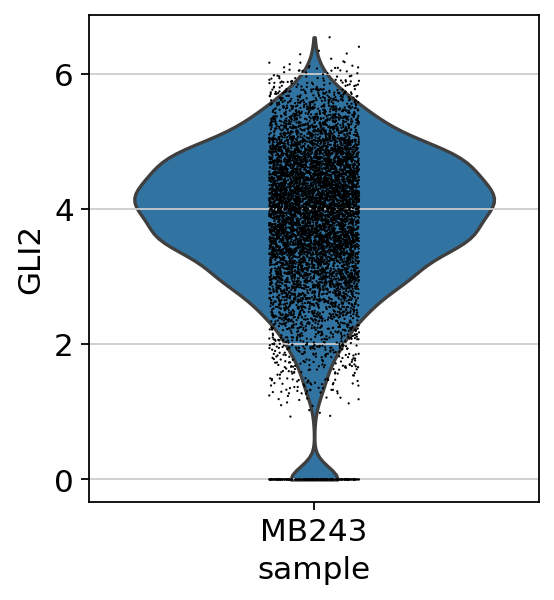

In [55]:
# rcParams['figure.figsize'] = 4.5,3
sc.pl.violin(adata, ['GLI2'], groupby='sample', save = '_MB243-Nuclei_GLI2_marker_visualization.pdf')

## PROJECT CHROMOTRIPSIS SIGNATURE ONTO THE EMBEDDING

In [25]:
f="/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/scRNA_analysis/MB_shh_filtered_table_FDR.tsv"
pos_df=pd.read_table(f, sep='\t')
pos_df=pos_df.loc[pos_df['log2FoldChange'] > 0,:]
pos_df=pos_df.loc[pos_df['padj'] <= 0.05,:]
neg_df=pd.read_table(f, sep='\t')
neg_df=neg_df.loc[neg_df['log2FoldChange'] < 0,:]
neg_df=neg_df.loc[neg_df['padj'] <= 0.05,:]

In [26]:
pos_df
neg_df

,ens_fullid,ens_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_name
409,ENSG00000187097.12_3,ENSG00000187097,1662.242563,-0.359350,0.109875,-3.270523,1.073486e-03,0.036798,ENTPD5
410,ENSG00000250462.8_2,ENSG00000250462,1332.612360,-0.407023,0.128259,-3.173454,1.506366e-03,0.045176,LRRC37BP1
411,ENSG00000076242.14_2,ENSG00000076242,4657.937488,-0.414492,0.112141,-3.696177,2.188700e-04,0.013763,MLH1
412,ENSG00000113812.13_3,ENSG00000113812,6868.479447,-0.436607,0.127945,-3.412451,6.438160e-04,0.026346,ACTR8
413,ENSG00000100890.15_3,ENSG00000100890,808.125224,-0.443807,0.140809,-3.151842,1.622438e-03,0.047158,KIAA0391
...,...,...,...,...,...,...,...,...,...
1042,ENSG00000237869.2,ENSG00000237869,12.804303,-5.767545,1.786001,-3.229307,1.240907e-03,0.040182,RP11-459O16.1
1043,ENSG00000183072.9_2,ENSG00000183072,260.545238,-5.943601,1.123514,-5.290188,1.220000e-07,0.000112,NKX2-5
1044,ENSG00000266736.1_2,ENSG00000266736,102.835417,-6.129589,1.766502,-3.469902,5.206490e-04,0.023260,RP11-260A9.4
1045,ENSG00000253226.1_2,ENSG00000253226,23.377382,-6.273874,1.701660,-3.686913,2.269910e-04,0.014047,HAUS1P3


In [27]:
gene_list_pos=pos_df['gene_name']
intersect_gene_list_pos=adata.var_names.isin(list(gene_list_pos))
gene_list_pos=adata.var_names[intersect_gene_list_pos]

In [28]:
len(gene_list_pos)

45

In [29]:
gene_list_neg=neg_df['gene_name']
intersect_gene_list_neg=adata.var_names.isin(list(gene_list_neg))
gene_list_neg=adata.var_names[intersect_gene_list_neg]

In [30]:
len(gene_list_neg)

200

In [31]:
sc.tl.score_genes(adata, list(gene_list_pos), ctrl_size=len(gene_list_pos), gene_pool=None, n_bins=25, score_name='Upregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)
sc.tl.score_genes(adata, list(gene_list_neg), ctrl_size=len(gene_list_neg), gene_pool=None, n_bins=25, score_name='Downregulated_Chromothripsis_Score', random_state=0, copy=False, use_raw=None)

computing score 'Upregulated_Chromothripsis_Score'
    finished: added
    'Upregulated_Chromothripsis_Score', score of gene set (adata.obs).
    796 total control genes are used. (0:00:00)
computing score 'Downregulated_Chromothripsis_Score'
    finished: added
    'Downregulated_Chromothripsis_Score', score of gene set (adata.obs).
    2857 total control genes are used. (0:00:00)


/home/przybilm/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


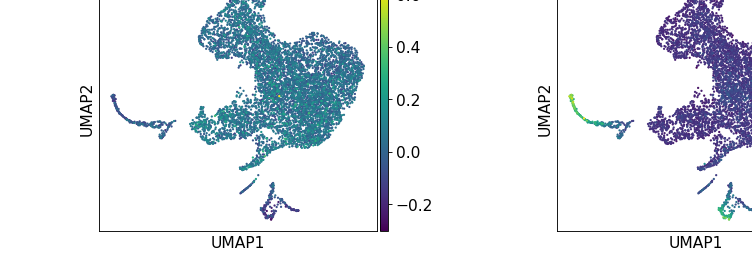

In [40]:
sc.pl.umap(adata, color=['Upregulated_Chromothripsis_Score', 'Downregulated_Chromothripsis_Score'], save = '_MB243-Nuclei_chromothripsisScore.pdf', wspace = 0.5)

In [34]:
# assign the column with the cell_type id in the metadata of the annData object
metadata = pd.DataFrame(adata.obs, index=adata.obs_names)
metadata.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/MB243-Nuclei_chromothripsisScore_metadata.csv')

In [41]:
metadata

,sample,technology,patient,scrublet__predicted_multiplet,scrublet__multiplet_scores,scrublet__multiplet_zscores,n_genes,n_genes_by_counts,total_counts,total_counts_mt,...,total_counts_ribo,pct_counts_ribo,louvain,leiden,new_clusters,clone_id,min_pval,chromothripsis_score,Upregulated_Chromothripsis_Score,Downregulated_Chromothripsis_Score
AAACCTGAGAAACCGC-1,MB243,Nuclei,MB243,False,0.034719,-27.183376,1606,1606,2524.0,3.0,...,12.0,0.475436,5,cluster1,malignant neuronal development,Clone3,0.001,0.001838,0.001838,-0.120067
AAACCTGAGAACAATC-1,MB243,Nuclei,MB243,False,0.099617,-7.996945,3564,3563,7115.0,15.0,...,42.0,0.590302,0,cluster0,malignant basal state,Clone2,0.001,0.049266,0.049266,-0.133942
AAACCTGAGCACCGTC-1,MB243,Nuclei,MB243,False,0.077209,-11.017576,3218,3215,5837.0,5.0,...,32.0,0.548227,4,cluster3,malignant cycling,Clone2,0.001,0.090227,0.090227,-0.137896
AAACCTGAGCAGCGTA-1,MB243,Nuclei,MB243,False,0.065341,-13.444356,2974,2974,5423.0,2.0,...,31.0,0.571639,0,cluster0,malignant basal state,Clone5,0.001,0.030149,0.030149,-0.094151
AAACCTGAGGAATTAC-1,MB243,Nuclei,MB243,False,0.052458,-17.300773,4180,4179,8695.0,11.0,...,60.0,0.690052,4,cluster3,malignant cycling,Clone2,0.001,-0.066851,-0.066851,-0.112462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAGTTCCTCCA-1,MB243,Nuclei,MB243,False,0.038988,-24.000467,2020,2019,3161.0,2.0,...,27.0,0.854160,0,cluster0,malignant basal state,Clone2,0.001,-0.030556,-0.030556,-0.108897
TTTGTCATCAATCACG-1,MB243,Nuclei,MB243,False,0.072134,-11.958865,3786,3785,7858.0,5.0,...,40.0,0.509035,4,cluster3,malignant cycling,Clone2,0.001,0.076236,0.076236,-0.090186
TTTGTCATCCCAACGG-1,MB243,Nuclei,MB243,False,0.103584,-7.596906,2499,2499,4407.0,5.0,...,28.0,0.635353,1,cluster1,malignant neuronal development,Clone5,0.001,0.032217,0.032217,-0.126545
TTTGTCATCGCTTGTC-1,MB243,Nuclei,MB243,False,0.065341,-13.444356,924,924,1126.0,2.0,...,10.0,0.888099,2,cluster0,malignant basal state,Clone2,0.001,0.197624,0.197624,-0.076729


In [43]:
data_crosstab = pd.crosstab(metadata['new_clusters'], metadata['clone_id'], margins = False)
print(data_crosstab)

clone_id                        Clone1  Clone2  Clone3  Clone4  Clone5  nan   
new_clusters                                                                  
malignant basal state                0    1169      82     257    1548       0
malignant neuronal development       2     676     426     281     350       0
malignant SHH                        0     300     535      56     145       0
malignant cycling                    1     254     207      70     337       0
macrophages                          0       0       0       0       0     224
astrocytes                           0       0       0       0       0     183
meninge cells                        0       0       0       0       0     165
endothelial cells                    0       0       0       0       0      34


In [44]:
data_crosstab.to_csv('/icgc/dkfzlsdf/analysis/B260/projects/przybilm/medulloblastoma/infercnv_MB/scRNA_scDNA/MB243-Nuclei_contingencyTable_celltypes_clones.csv')